In [2]:
import torch 
import numpy as np 
import h5py 
import matplotlib.pyplot as plt 
from torch import Tensor

device = torch.device('cpu')

In [3]:
def extract_and_flatten_multicoil_kspace_patches(
        inp: Tensor,       # k-space tensor of shape [batch_size, coils, nfe, np]
        kernel_size=(5,5), # tuple of (frequency, phase) encoding kernel sizes 
        stride=(1,1),       # acceleration factor along each dimension 
        pad=False,
):
    
    if pad:
        K,L = kernel_size 
        pad_height_total = K - 1
        pad_width_total = L - 1
        pad_top = pad_height_total // 2
        pad_bottom = pad_height_total - pad_top
        pad_left = pad_width_total // 2
        pad_right = pad_width_total - pad_left
        inp = torch.nn.functional.pad(inp, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0)
    
    batch_size = inp.shape[0]
    patches = torch.nn.functional.unfold(inp, kernel_size=kernel_size, stride=stride)
    num_patches = patches.shape[2]
    patches = patches.transpose(1,2).reshape(batch_size, num_patches, -1)

    return patches 

def extract_point_within_multicoil_kspace_patch(
        inp: Tensor,
        kernel_size=(5,5),
        stride=(1,1),
        shift=(2,2)  
):
    batch_size, num_coils, _, _ = inp.shape
    patches = torch.nn.functional.unfold(inp, kernel_size=kernel_size, stride=stride)
    num_patches = patches.shape[2]
    row_shift, col_shift = shift
    row_kernel_size, col_kernel_size = kernel_size
    shifted_index = row_shift * col_kernel_size + col_shift
    extracted_point = patches.reshape(batch_size, num_coils, -1, num_patches)[:, :, shifted_index, :]
    return extracted_point

def reshape_flattened_patches(
        inp: Tensor,        # Flattened patches tensor of shape [B, K]
        num_coils: int,
        kernel_size=(5,5)  # tuple of (frequency, phase) encoding kernel sizes
    ):

    batch_size = inp.shape[0]
    freq_kernel_size, phase_kernel_size = kernel_size

    # Reshape the tensor
    reshaped_tensor = inp.reshape(batch_size, num_coils, freq_kernel_size, phase_kernel_size)

    return reshaped_tensor

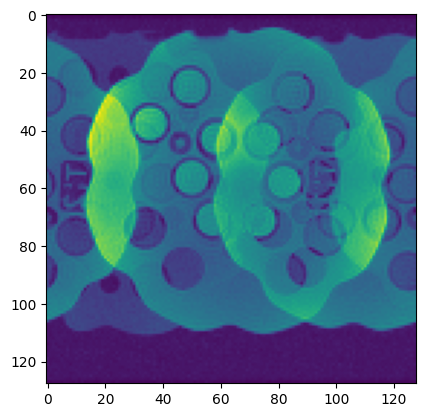

torch.Size([1, 32, 128, 128])
torch.Size([3, 32, 128, 128])
torch.Size([1, 1, 15876, 288])
torch.Size([3, 32, 15876, 1])


In [20]:
from matrix_mri.recon import fft2d, ifft2d

contrast = 2

datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_12_03_CMT_2D/_Series_0000/recon.h5'
with h5py.File(datapath,'r') as F:
    ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]

aliased_datapath = '/Users/nmickevicius/data/20250115_three_band_CMT/20250115_10_19_18_CMT_2D/_Series_0000/recon.h5'
with h5py.File(aliased_datapath,'r') as F:
    aliased_ksp = np.array(F['ksp'], dtype=np.complex64)[:,:,:,0,contrast]
aliased_img = ifft2d(aliased_ksp, dims=(0,1)) 
aliased_rec = np.sqrt(np.sum(np.abs(aliased_img * aliased_img.conj()), axis=-1))
plt.figure()
plt.imshow(aliased_rec)
plt.show()

img = ifft2d(ksp, dims=(0,1))
img = np.stack([img[:,:128,:], img[:,128:256,:],img[:,256:,:]], axis=-1)
data = fft2d(img, dims=(0,1))

# add CAIPI shifts to calibration data 
data[:,1::3,:,0] = data[:,1::3,:,0] * np.exp(1j*2*np.pi/3)
data[:,2::3,:,0] = data[:,2::3,:,0] * np.exp(1j*4*np.pi/3)
data[:,1::3,:,2] = data[:,1::3,:,2] * np.exp(-1j*2*np.pi/3)
data[:,2::3,:,2] = data[:,2::3,:,2] * np.exp(-1j*4*np.pi/3)

# source = torch.tensor(data.transpose(3,2,0,1), dtype=torch.complex64, device=device) 
# target = torch.sum(source, dim=0, keepdim=True)

target = torch.tensor(data.transpose(3,2,0,1), dtype=torch.complex64, device=device) 
source = torch.sum(target, dim=0, keepdim=True)

print(source.shape)
print(target.shape)

kernel_size = (3,3) 
shift = (1,1) 
num_coils = source.shape[1] 

# fit the kernels 
# A = extract_and_flatten_multicoil_kspace_patches(source, kernel_size=kernel_size)[:,None,:,:]
# Y = extract_point_within_multicoil_kspace_patch(target, kernel_size=kernel_size, shift=shift)[...,None]
# X = torch.linalg.lstsq(A, Y, rcond=None)[0]

A = extract_and_flatten_multicoil_kspace_patches(source, kernel_size=kernel_size)[:,None,:,:]
Y = extract_point_within_multicoil_kspace_patch(target, kernel_size=kernel_size, shift=shift)[...,None]
X = torch.linalg.lstsq(A, Y, rcond=None)[0]
print(A.shape) 
print(Y.shape)


torch.Size([1, 1, 16384, 288])
torch.Size([3, 32, 128, 128])
(128, 128, 3)


<function matplotlib.pyplot.show(close=None, block=None)>

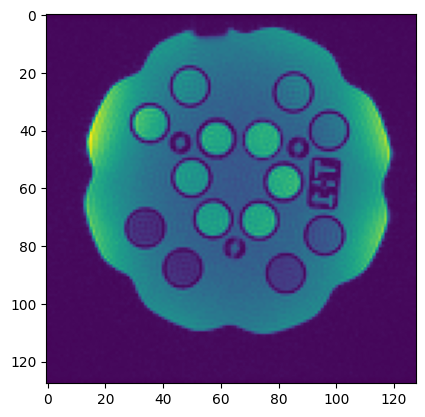

In [25]:
aliased_source = torch.tensor(aliased_ksp[None,...].transpose(0,3,1,2))
A_test = extract_and_flatten_multicoil_kspace_patches(aliased_source, kernel_size=kernel_size, pad=True)[:,None,:,:]
print(A_test.shape)
AX = A_test@X 
AX = AX.view(3, 32, 128, 128)
print(AX.shape)

recon = AX.detach().cpu().numpy().transpose(2,3,0,1)
recon = ifft2d(recon, dims=(0,1))
recon = np.sqrt(np.sum(np.abs(recon * recon.conj()), axis=-1))
print(recon.shape) 

plt.figure()
plt.imshow(recon[:,:,1])
plt.show

In [51]:
print(source.shape)
print(W.shape) 

torch.nn.functional.conv2d(source, W, )

torch.Size([3, 32, 128, 128])
torch.Size([3, 32, 3, 3])


In [ ]:
kernel_size = (3,3)
shift = (1,1)
num_coils = 32 

target = torch.rand((3,num_coils,128,16), dtype=torch.complex64, device=device)
source = torch.rand((1,num_coils,128,16), dtype=torch.complex64, device=device)

A = extract_and_flatten_multicoil_kspace_patches(source, kernel_size=kernel_size)[:,None,:,:]
Y = extract_point_within_multicoil_kspace_patch(target, kernel_size=kernel_size, shift=shift)[...,None]

X = torch.linalg.lstsq(A, Y, rcond=None)[0]

W = reshape_flattened_patches(X[0,:,:,0], num_coils, kernel_size=kernel_size)

print(W.shape) 
# print(x.shape)
# print(y.shape)

